In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
def load_file(filepath, **kwargs):
    """
    Detects file extension and uses the appropriate pandas function.
    """
    if not os.path.exists(filepath):
        print(f"Error: File not found: {filepath}")
        return None
    ext = os.path.splitext(filepath)[1].lower()
    if ext in ['.xlsx', '.xls']:
        # Engine 'openpyxl' is required for xlsx
        return pd.read_excel(filepath, engine='openpyxl', **kwargs)
    elif ext == '.csv':
        return pd.read_csv(filepath, **kwargs)
    else:
        print(f"Error: Unsupported file extension '{ext}' for file {filepath}")
        return None

In [3]:
trp_file = "QUARTERLY_DATA.xlsx"
trp = load_file(trp_file)

In [4]:
trp_data = pd.DataFrame()

In [5]:
if trp is not None:
    # Clean Quarter/Year column
    trp['Quarter/Year'] = trp['Quarter/Year'].astype(str).str.upper().str.strip()

In [6]:
    def parse_quarter(s):
        try:
            if 'Q' in s:
                parts = s.split()  # e.g. "Q1 2015" -> ["Q1", "2015"]
                if len(parts) >= 2:
                    q = parts[0]
                    y = parts[1]
                    return pd.Period(f"{y}{q}", freq='Q')
            return pd.NaT
        except:
            return pd.NaT

In [7]:
    trp['Period'] = trp['Quarter/Year'].apply(parse_quarter)
    trp = trp.dropna(subset=['Period']).set_index('Period').sort_index()
    if 'Gross Margin(%)' in trp.columns:
        trp_data = trp[['Gross Margin(%)']].rename(columns={'Gross Margin(%)': 'Gross Margin'})
    else:
        print("Column 'Gross Margin(%)' not found in TRP data.")

In [8]:
energy_file = "pret_energie_ro.csv"
energy = load_file(energy_file)
energy_q = pd.Series(dtype='float64')

In [9]:
if energy is not None:
    if 'ISO3 Code' in energy.columns:
        energy_ro = energy[energy['ISO3 Code'] == 'ROU'].copy()
        energy_ro['Date'] = pd.to_datetime(energy_ro['Date'], format='%d/%m/%Y')
        energy_ro = energy_ro.set_index('Date').sort_index()

        # Handle Resampling (QE = Quarter End for new pandas, Q for old)
        try:
            energy_q = energy_ro['Price (EUR/MWhe)'].resample('QE').mean()
        except ValueError:
            energy_q = energy_ro['Price (EUR/MWhe)'].resample('Q').mean()
        energy_q.name = 'Energy Price'
        energy_q.index = energy_q.index.to_period('Q')

In [10]:
def process_commodity(filename, col_name):
    # Bloomberg Excel exports usually have metadata in first 6 rows
    df = load_file(filename, skiprows=6)
    if df is None:
        return None
    if 'Date' in df.columns:
        df = df.dropna(subset=['Date'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date').sort_index()
        try:
            q_df = df['PX_LAST'].resample('QE').mean()
        except ValueError:
            q_df = df['PX_LAST'].resample('Q').mean()
        q_df.name = col_name
        q_df.index = q_df.index.to_period('Q')
        return q_df
    return None

In [11]:
pvc_q = process_commodity("PVC (1).xlsx", 'PVC Price')
pe_q = process_commodity("2 (1).xlsx", 'PE Price')
pp_q = process_commodity("1 (1).xlsx", 'PP Price')

In [12]:
dfs_to_merge = [trp_data, pp_q, pe_q, pvc_q, energy_q]
# Filter out None values or empty series
dfs_to_merge = [d for d in dfs_to_merge if d is not None and not d.empty]


--- Rebased Quarterly Data Head ---
        Gross Margin    PP Price    PE Price   PVC Price  Energy Price
2015Q1    100.000000  100.000000  100.000000  100.000000    100.000000
2015Q2     89.198756  123.938136  131.583076  123.056830     79.584301
2015Q3     77.905960  105.929455  121.976379  126.246672    113.283418
2015Q4    101.940277   97.851179  114.423294  108.322537    107.174910
2016Q1     83.142521   85.548331  106.186284  104.357073     85.679555


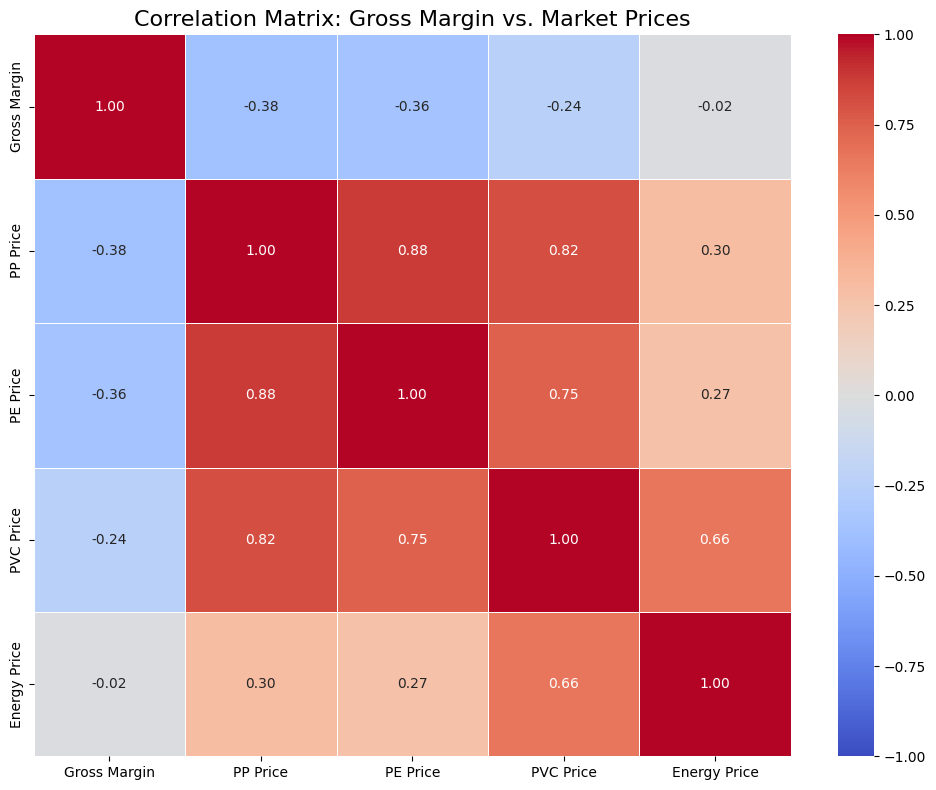

Correlation Heatmap saved as 'correlation_heatmap.png'.


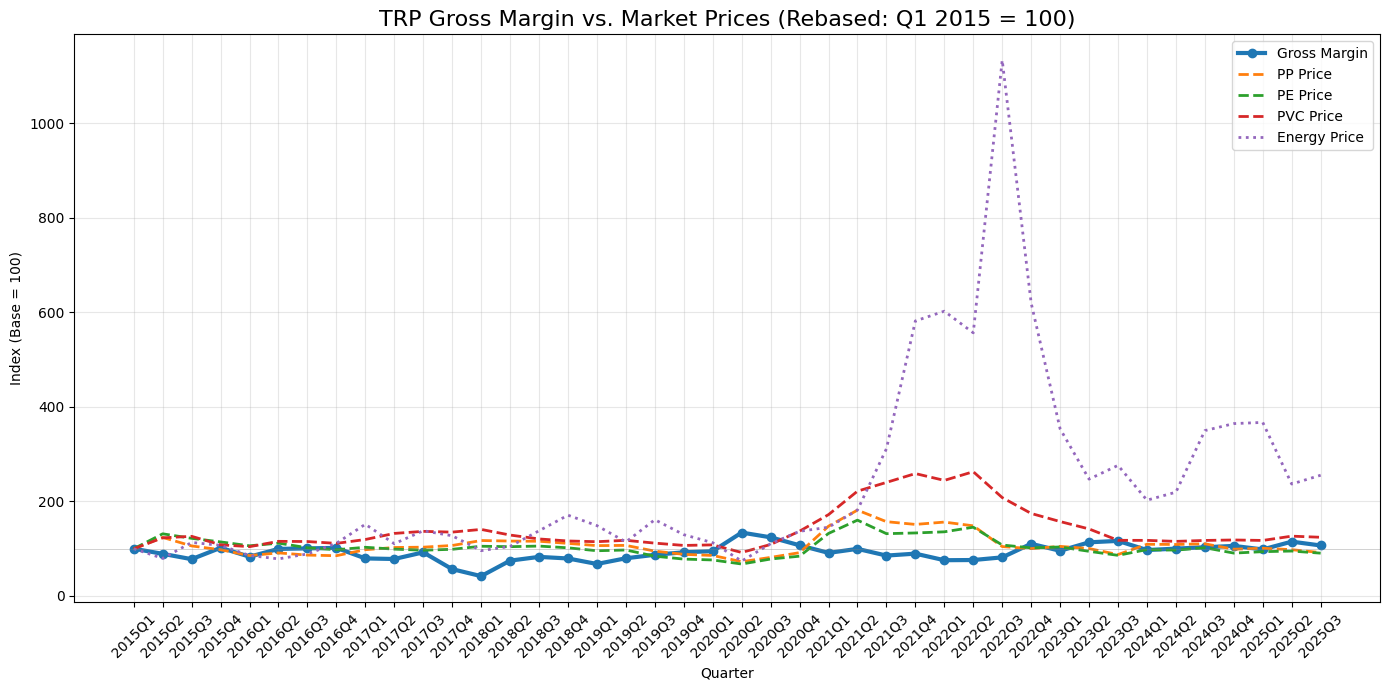

Rebased Trends Chart saved as 'rebased_trends_chart.png'.


In [13]:
if len(dfs_to_merge) > 1:
    merged = pd.concat(dfs_to_merge, axis=1, join='inner')

    # Rebase to 100 (Index = 100 at Start)
    rebased_data = merged / merged.iloc[0] * 100
    print("\n--- Rebased Quarterly Data Head ---")
    print(rebased_data.head())

    # --- 5. Generate Charts ---

    # CHART 1: Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = merged.corr()

    # Create Heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix: Gross Margin vs. Market Prices', fontsize=16)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
    print("Correlation Heatmap saved as 'correlation_heatmap.png'.")

    # CHART 2: Rebased Trends
    plt.figure(figsize=(14, 7))

    # Plot Gross Margin (Bold)
    if 'Gross Margin' in rebased_data.columns:
        plt.plot(rebased_data.index.astype(str), rebased_data['Gross Margin'],
                 label='Gross Margin', linewidth=3, color='tab:blue', marker='o')

    # Plot Commodity Prices (Dashed)
    if 'PP Price' in rebased_data.columns:
        plt.plot(rebased_data.index.astype(str), rebased_data['PP Price'],
                 label='PP Price', linestyle='--', linewidth=2, color='tab:orange')
    if 'PE Price' in rebased_data.columns:
        plt.plot(rebased_data.index.astype(str), rebased_data['PE Price'],
                 label='PE Price', linestyle='--', linewidth=2, color='tab:green')
    if 'PVC Price' in rebased_data.columns:
        plt.plot(rebased_data.index.astype(str), rebased_data['PVC Price'],
                 label='PVC Price', linestyle='--', linewidth=2, color='tab:red')

    # Plot Energy Price (Dotted)
    if 'Energy Price' in rebased_data.columns:
        plt.plot(rebased_data.index.astype(str), rebased_data['Energy Price'],
                 label='Energy Price', linestyle=':', linewidth=2, color='tab:purple')

    # Add baseline at 100
    plt.axhline(100, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    plt.title('TRP Gross Margin vs. Market Prices (Rebased: Q1 2015 = 100)', fontsize=16)
    plt.xlabel('Quarter')
    plt.ylabel('Index (Base = 100)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save and Show
    plt.savefig('rebased_trends_chart.png')
    plt.show()
    print("Rebased Trends Chart saved as 'rebased_trends_chart.png'.")

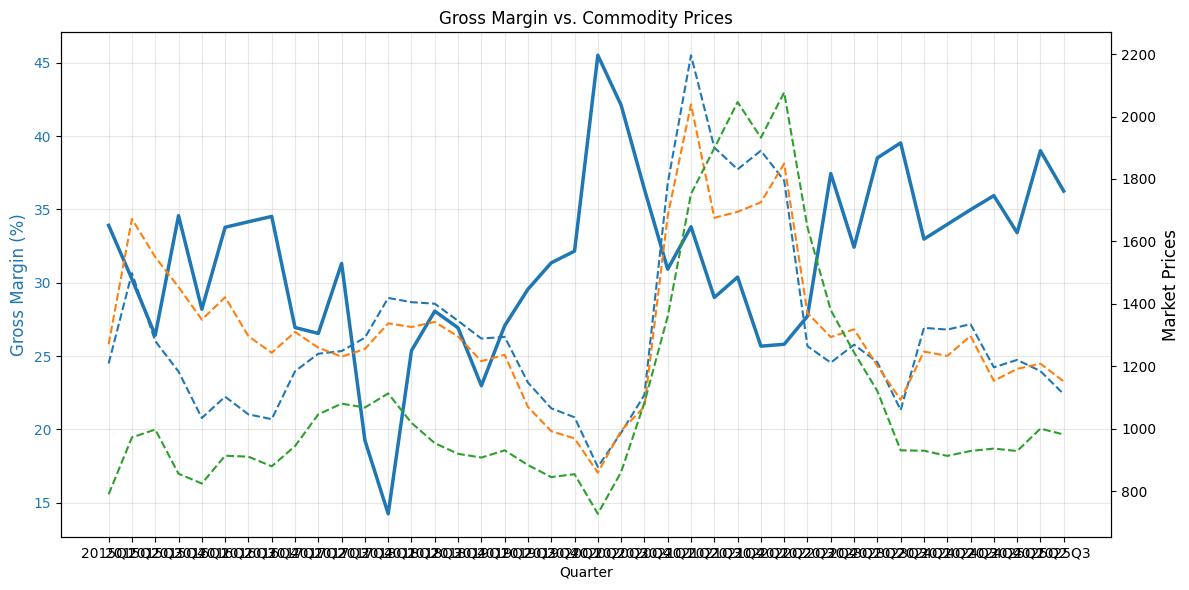

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Gross Margin (%)', color=color, fontsize=12)
ax1.plot(merged.index.astype(str), merged['Gross Margin'], color=color, linewidth=2.5, label='Gross Margin')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Market Prices', color='black', fontsize=12)
ax2.plot(merged.index.astype(str), merged['PP Price'], linestyle='--', label='PP Price')
ax2.plot(merged.index.astype(str), merged['PE Price'], linestyle='--', label='PE Price')
ax2.plot(merged.index.astype(str), merged['PVC Price'], linestyle='--', label='PVC Price')
# Note: Energy is on a different scale, so it might appear flat on this axis.

plt.title('Gross Margin vs. Commodity Prices')
plt.tight_layout()
plt.savefig('trends_chart.png')
plt.show()